# Computational Finance
## Lab Assignment 1
### Adrian + Daan + Menno 

In [76]:
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

### 1. Option Valuation using Binomial Trees

We are trying to provide the risk-free fair price for an Option Call, a financial derivative that gives the option holder the right to buy an underlying security at one or many future events.

We assume:

- A two state economy, the price of the underlying can go up or down
- Money can be invested risk free for a constant interest rate
- There is no arbitrage or transaction costs

In [77]:
def binomialTree(S, sigma, T, N, r, K, option_type='Call', origin = 'European'):
    # Time step
    dt = T / N

    # Possible price movements
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))

    # Matrix that will hold the values
    matrix = tree = np.zeros((N + 1, N + 1))

    matrix[0, 0] = S

    # Populate the matrix with the stock price progression
    for i in np.arange(1, N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            if j == 0:
                matrix[i, j] = matrix[i-1, j] * d
            else:
                matrix[i, j] = matrix[i-1, j-1] * u

    # Price at each step
    p = (np.exp(r*dt) - d) / (u - d)

    # Hedge amount at each step
    # delta = (up - down) / (s * u - s * d)

    columns = tree.shape[1] 
    rows = tree.shape[0]

    # Calculate the price for the expiration day nodes
    for c in np.arange(columns):
        S = tree[rows - 1, c] # Value in the matrix
        if option_type == 'Call':
            tree[rows - 1, c] =  max(0, S - K) 
        else: 
            tree[rows - 1, c] =  max(0, K - S) # Put option

    # Backwards Induction through the nodes
    for i in np.arange(rows - 1)[:: -1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            if origin == "European":
                tree[i, j] = np.exp(-r*dt) * (p * up + (1-p) * down)

            elif origin == 'American':
                tree[i, j] = max(tree[i, j] - K, np.exp(-r*dt) * (p * up + (1-p) * down))
    
    return tree[0][0]

In [78]:
def blackSholes(S, K, t, r, sigma, option_type='Call'):
    # Time to maturity
    tau = T - t

    # Parameters
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    # Hedge amount at t
    delta = norm.cdf(d1)

    if option_type == 'Call':
        call_price = S * norm.cdf(d1) - np.exp(-r*tau) * K * norm.cdf(d2)
        return call_price, delta
    else:
        put_price = (np.exp(-r*tau) * K * norm.cdf(-d2)) - (S * norm.cdf(-d1))
        return put_price, delta

In [79]:
# Option Parameters
S = S0 = 100 # Starting stock price
K = 99 # Strike price
T = 1 # Time of maturity
t = 0 # Current period
N = 50 # Amount of steps, possible price changes
r = 0.06 # Risk free interest rate
sigma = vol = 0.2 # Volatility of the stock

In [80]:
test_bt = binomialTree(S, sigma, T, N, r, K)
print(test_bt)

test_bs = blackSholes(S, K, t, r, sigma)
print(test_bs[0])

11.546434850755034
11.544280227051097


In [84]:
def plot_errors(max_steps=500):
    bs_price = blackSholes(S, K, t, r, sigma)[0]
    errors = []
    steps = []

    for N in range(30, max_steps, 5):
        errors.append(abs(bs_price-binomialTree(S, sigma, T, N, r, K)))
        steps.append(N)
    plt.plot(steps,errors)
    plt.xlabel('Step')
    plt.ylabel('Error')

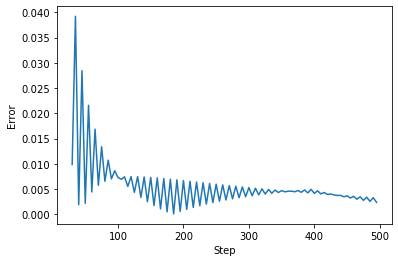

In [85]:
plot_errors()

In [86]:
def plot_difference(max_steps=500):
    bs_price = bs_price = blackSholes(S, K, t, r, sigma)[0]
    tree_price = []
    steps = []
    for N in range(30, max_steps, 5):
        tree_price.append(binomialTree(S, sigma, T, N, r, K))
        steps.append(N)
    plt.plot(steps,tree_price,label='Binomial Tree')
    plt.xlabel('Steps')
    plt.ylabel('Option Price')
    plt.plot([steps[0],steps[-1]],[bs_price,bs_price],color='Black',label='Black Sholes')
    plt.legend()

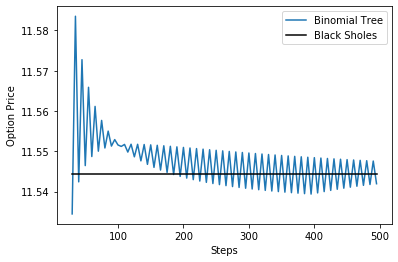

In [87]:
plot_difference()

In [95]:
def plot_volatility():
    sigmas = []
    hedges = []
    for sigma in np.linspace(0,1,11):
        hedges.append(blackSholes(S, K, t, r, sigma)[1])
        sigmas.append(sigma)
    plt.plot(sigmas, hedges)
    plt.xlabel('Volatility')
    plt.ylabel('Hedge')

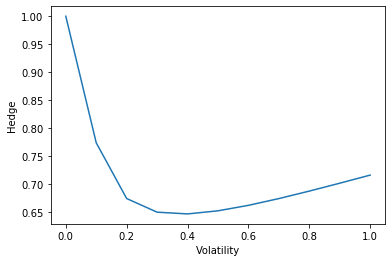

In [96]:
plot_volatility()